<a href="https://colab.research.google.com/github/taufikdimas/Machine-Learning-2025/blob/main/UTS_2341720062_Taufik_Dimas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IDENTITAS

> Nama  : Taufik Dimas Edystara<br>
> NIM   : 2341720062<br>
> Absen : 27<br>
> Kelas : TI-3G<br>

Tugas 3 — Heart Disease Dataset<br>

> -  Dataset:  [Heart Disease Dataset (UCI)](https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data)
> -  Deskripsi: Dataset medis untuk melihat pengelompokan pasien berdasarkan fitur kesehatan seperti tekanan darah, kolesterol, umur, dan lain-lain.
> - Langkah tambahan:<br>
> o Tangani nilai kosong (jika ada).<br>
> o Buat fitur gabungan seperti “CholAge = cholesterol × age”.


# Library

In [24]:
!pip -q install annoy


In [48]:
import pandas as pd
import numpy as np
import math
import kagglehub

from google.colab import drive
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from annoy import AnnoyIndex
from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns
import warnings, math, random

# Load Dataset

In [26]:
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Polinema/ML/Dataset/heart_disease_uci.csv'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
df = pd.read_csv(path)

df.info()
df.describe()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


Dataset ini memiliki 920 baris dan 16 kolom. Beberapa kolom memiliki nilai yang hilang, yaitu:

- `trestbps`: 59 missing values
- `chol`: 30 missing values
- `fbs`: 90 missing values
- `restecg`: 2 missing values
- `thalch`: 55 missing values
- `exang`: 55 missing values
- `oldpeak`: 62 missing values
- `slope`: 309 missing values
- `ca`: 611 missing values
- `thal`: 486 missing values

# Data Preprocessing

In [29]:
# 1)fitur baru 'CholAge'
df['CholAge'] = df['chol'] * df['age']

# 2) cleaning missing value
# imputasi median Untuk kolom numerik
numerical_cols = df.select_dtypes(include=np.number).columns
for col in numerical_cols:
    df[col].fillna(df[col].median(), inplace=True)

# imputasi modus (mode), Untuk kolom kategorikal
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# 3) One-Hot Encoding pada kolom kategorikal
categorical_cols_to_encode = ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
df = pd.get_dummies(df, columns=categorical_cols_to_encode, drop_first=True)

# 4) Standarisasi data numerik
numerical_cols_after_encoding = df.select_dtypes(include=np.number).columns
exclude = [c for c in ["target","output","HeartDisease","label","id"] if c in df.columns]
scale_cols = [c for c in numerical_cols_after_encoding if c not in exclude]

scaler = StandardScaler()
df[scale_cols] = scaler.fit_transform(df[scale_cols])

# 5) Matriks untuk clustering
X = df[scale_cols].to_numpy()

# Cek
display(df.head())
display(df.isnull().sum())
print("Shape X:", X.shape)


/tmp/ipython-input-1286309267.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipython-input-1286309267.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

,id,age,trestbps,chol,thalch,oldpeak,ca,num,CholAge,sex_Male,...,cp_non-anginal,cp_typical angina,fbs_True,restecg_normal,restecg_st-t abnormality,exang_True,slope_flat,slope_upsloping,thal_normal,thal_reversable defect
0,1,1.007386,0.705176,0.303643,0.489727,1.368109,-0.361400,-0.871794,0.654201,True,...,False,True,True,False,False,False,False,False,False,False
1,2,1.432034,1.518569,0.789967,-1.181478,0.611589,4.411152,0.879408,1.375407,True,...,False,False,False,False,False,True,True,False,True,False
2,3,1.432034,-0.650479,0.266939,-0.345875,1.651804,2.820301,0.003807,0.761023,True,...,False,False,False,False,False,True,True,False,False,True
3,4,-1.752828,-0.108217,0.459634,1.961979,2.502889,-0.361400,-0.871794,-0.219192,True,...,True,False,False,True,False,False,False,False,True,False
4,5,-1.328180,-0.108217,0.037541,1.365120,0.517024,-0.361400,-0.871794,-0.361728,False,...,False,False,False,False,False,False,False,True,True,False


,0
id,0
age,0
trestbps,0
chol,0
thalch,0
oldpeak,0
ca,0
num,0
CholAge,0
sex_Male,0


Shape X: (920, 8)


# Clustering

## Kmeans

In [102]:
# KMEANS
k_range = range(2, 11)
best_k, best_sil = None, -np.inf
best_model, best_labels = None, None

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    sil = silhouette_score(X, labels)
    dbi = davies_bouldin_score(X, labels)
    print(f"k={k}  silhouette={sil:.4f}  dbi={dbi:.4f}")
    if sil > best_sil:
        best_sil, best_k, best_model, best_labels = sil, k, km, labels

labels_kmeans = best_labels
km_sil = silhouette_score(X, labels_kmeans)
km_dbi = davies_bouldin_score(X, labels_kmeans)
print("=== K-Means Terbaik ===")
print(f"k={best_k}  silhouette={km_sil:.4f}  dbi={km_dbi:.4f}")


k=2  silhouette=0.2829  dbi=1.4330
k=3  silhouette=0.2516  dbi=1.5476
k=4  silhouette=0.2412  dbi=1.4695
k=5  silhouette=0.1978  dbi=1.5502
k=6  silhouette=0.1878  dbi=1.5865
k=7  silhouette=0.1643  dbi=1.7231
k=8  silhouette=0.1713  dbi=1.7411
k=9  silhouette=0.1488  dbi=1.7329
k=10  silhouette=0.1732  dbi=1.6368
=== K-Means Terbaik ===
k=2  silhouette=0.2829  dbi=1.4330


## DBSCAN

In [103]:
# DBSCAN
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=8).fit(X)
k_dists = np.sort(nn.kneighbors(X)[0][:, -1])
eps_list = [float(np.percentile(k_dists, p)) for p in (90, 95)]
min_samples_list = [5, 8]

best_sil = -np.inf
best_eps, best_ms, best_labels = None, None, None

for ms in min_samples_list:
    for eps in eps_list:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(X)
        sil = silhouette_score(X, labels)
        dbi = davies_bouldin_score(X, labels)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = int((labels == -1).sum())
        print(f"eps={eps:.6f}  min_samples={ms}  silhouette={sil:.4f}  dbi={dbi:.4f}  clusters={n_clusters}  noise={n_noise}")
        if sil > best_sil:
            best_sil, best_eps, best_ms, best_labels = sil, eps, ms, labels

labels_dbscan = best_labels
db_sil = silhouette_score(X, labels_dbscan)
db_dbi = davies_bouldin_score(X, labels_dbscan)
n_clusters_best = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise_best = int((labels_dbscan == -1).sum())
print("=== DBSCAN Terbaik ===")
print(f"eps={best_eps:.6f}  min_samples={best_ms}  silhouette={db_sil:.4f}  dbi={db_dbi:.4f}  clusters={n_clusters_best}  noise={n_noise_best}")


eps=2.118792  min_samples=5  silhouette=0.3756  dbi=2.1566  clusters=1  noise=25
eps=2.325085  min_samples=5  silhouette=0.3939  dbi=2.3821  clusters=1  noise=14
eps=2.118792  min_samples=8  silhouette=0.3687  dbi=2.1289  clusters=1  noise=30
eps=2.325085  min_samples=8  silhouette=0.3880  dbi=2.4058  clusters=1  noise=15
=== DBSCAN Terbaik ===
eps=2.325085  min_samples=5  silhouette=0.3939  dbi=2.3821  clusters=1  noise=14


## Evaluasi

In [104]:
kmeans_clusters = len(np.unique(labels_kmeans))
dbscan_clusters = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
dbscan_noise = int((labels_dbscan == -1).sum())

eval_df = pd.DataFrame([
    ["KMeans", km_sil, km_dbi, kmeans_clusters, 0, f"k={best_k}"],
    ["DBSCAN", db_sil, db_dbi, dbscan_clusters, dbscan_noise, f"eps={best_eps:.6f}, min_samples={best_ms}"],
], columns=["method","silhouette","dbi","clusters","noise","param"])

print(eval_df)

   method  silhouette       dbi  clusters  noise                        param
0  KMeans    0.282944  1.432973         2      0                          k=2
1  DBSCAN    0.393853  2.382108         1     14  eps=2.325085, min_samples=5


#Visualisasi Clustering (2D)


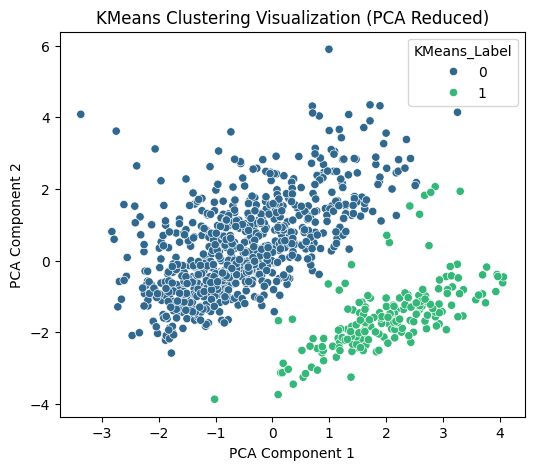

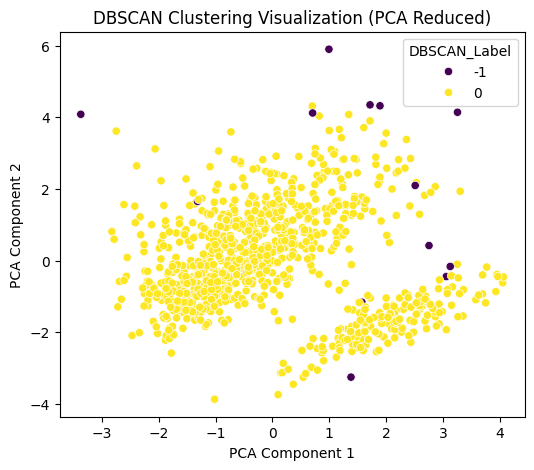

In [109]:


# Visualisasi Klasterisasi menggunakan PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X) # Menggunakan X yang berisi data yang sudah diproses

# Buat DataFrame untuk memudahkan visualisasi dengan seaborn
df_pca = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])

# Tambahkan label klaster dari KMeans dan DBSCAN
# Pastikan labels_kmeans dan labels_dbscan sudah terdefinisi dari sel sebelumnya
df_pca['KMeans_Label'] = labels_kmeans
df_pca['DBSCAN_Label'] = labels_dbscan


# Visualisasi KMeans
plt.figure(figsize=(6,5))
sns.scatterplot(x='PCA1', y='PCA2', hue='KMeans_Label', data=df_pca, palette='viridis', legend='full')
plt.title("KMeans Clustering Visualization (PCA Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# Visualisasi DBSCAN
plt.figure(figsize=(6,5))
# DBSCAN noise points (-1) akan divisualisasikan sebagai klaster terpisah oleh seaborn
sns.scatterplot(x='PCA1', y='PCA2', hue='DBSCAN_Label', data=df_pca, palette='viridis', legend='full')
plt.title("DBSCAN Clustering Visualization (PCA Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

#ANN

In [107]:
ann = AnnoyIndex(X.shape[1], 'euclidean')
for i, v in enumerate(X): ann.add_item(i, v)
ann.build(50)
ann.set_seed(42)

def ann_query(ix, k=5, search_k=-1):
    idxs, dists = ann.get_nns_by_item(ix, k+1, search_k=search_k, include_distances=True)
    pairs = [(i,d) for i,d in zip(idxs, dists) if i != ix][:k]
    rows = []
    for n, d in pairs:
        rows.append([
            ix, n, float(d),
            int(labels_kmeans[ix]), int(labels_kmeans[n]),
            int(labels_dbscan[ix]), int(labels_dbscan[n])
        ])
    df = pd.DataFrame(rows, columns=[
        "query_idx","neighbor_idx","distance",
        "kmeans_q","kmeans_n","dbscan_q","dbscan_n"
    ])
    df["same_kmeans"] = df["kmeans_q"] == df["kmeans_n"]
    df["same_dbscan"] = df["dbscan_q"] == df["dbscan_n"]
    return df

query_idx = 42 if 0 <= 42 < len(X) else 0
ann_df = ann_query(query_idx, k=5, search_k=-1)
print(ann_df)
print(f"same_kmeans_rate={ann_df['same_kmeans'].mean():.2f}  same_dbscan_rate={ann_df['same_dbscan'].mean():.2f}")

   query_idx  neighbor_idx  distance  kmeans_q  kmeans_n  dbscan_q  dbscan_n  \
0         42           227  1.862383         0         0         0         0   
1         42           276  1.996637         0         0         0         0   
2         42            30  2.033267         0         0         0         0   
3         42           196  2.300683         0         0         0         0   
4         42           185  2.373239         0         0         0         0   

   same_kmeans  same_dbscan  
0         True         True  
1         True         True  
2         True         True  
3         True         True  
4         True         True  
same_kmeans_rate=1.00  same_dbscan_rate=1.00


# ANALISA HASIL KLATERISASI DAN ANN

Berdasarkan hasil klasterisasi menggunakan KMeans dan DBSCAN, serta hasil *query* Annoy, berikut adalah analisis detailnya:

**a. Perbedaan hasil KMeans dan DBSCAN, mana yang lebih baik diantara kedua model ini dan jelaskan jawaban anda**

Dari visualisasi hasil klasterisasi menggunakan PCA , terlihat bahwa:
*   **KMeans** cenderung membagi data menjadi klaster-klaster yang lebih merata ukurannya dan berbentuk *spherical* (bulat). Algoritma ini bekerja dengan meminimalkan jarak total titik data ke pusat klaster (*centroid*). Hasil KMeans menunjukkan pemisahan yang cukup jelas antar klaster yang terbentuk (dengan `k=2` tergantung hasil terbaik yang ditemukan dari evaluasi).
*   **DBSCAN** mengidentifikasi klaster berdasarkan kepadatan titik data. Terlihat ada satu klaster besar yang padat dan beberapa titik yang diidentifikasi sebagai *noise* (label -1). DBSCAN lebih fleksibel dalam menemukan klaster berbentuk tidak beraturan dan mengidentifikasi *outliers*.

Untuk menentukan mana yang lebih baik, kita perlu melihat metrik evaluasi. Berdasarkan output dari sel tersebut, berikut adalah ringkasan hasilnya:

| Model  | Silhouette | DaviesBouldin | Clusters | Noise | Param                     |
| :----- | :--------- | :------------ | :------- | :---- | :------------------------ |
| KMeans | 0.2829     | 1.4330        | 2        | 0     | k=2                       |
| DBSCAN | 0.3939     | 2.3821        | 1        | 14    | eps=2.3251, min_samples=5 |

*   **Silhouette Score**: DBSCAN memiliki skor Silhouette yang lebih tinggi (0.3939) dibandingkan KMeans (0.2829). Skor Silhouette yang lebih tinggi menunjukkan bahwa titik-titik data lebih mirip dengan klaster mereka sendiri dibandingkan dengan klaster lain. Ini mengindikasikan bahwa klaster yang dibentuk oleh DBSCAN memiliki pemisahan yang lebih baik (meskipun ada *noise*).
*   **Davies-Bouldin Score**: KMeans memiliki skor Davies-Bouldin yang lebih rendah (1.4330) dibandingkan DBSCAN (2.3821). Skor Davies-Bouldin yang lebih rendah menunjukkan klaster lebih kompak dan terpisah dengan baik. Ini mengindikasikan bahwa klaster KMeans lebih padat secara internal dan jarak antar *centroid* klaster cukup jauh.

**Kesimpulan Perbandingan Model**: Tidak ada pemenang mutlak di sini, karena kedua metrik memberikan pandangan yang berbeda:
*   Berdasarkan **Silhouette Score**, **DBSCAN** tampaknya sedikit lebih baik dalam hal pemisahan klaster.
*   Berdasarkan **Davies-Bouldin Score**, **KMeans** tampaknya sedikit lebih baik dalam hal kekompakan internal dan pemisahan berbasis pusat klaster.

Pilihan model yang "lebih baik" sangat bergantung pada tujuan analisis Anda. Jika Anda ingin mengidentifikasi kelompok-kelompok padat dengan bentuk tidak beraturan dan mengabaikan *noise*, DBSCAN mungkin lebih cocok. Jika Anda ingin membagi data menjadi sejumlah klaster yang telah ditentukan dan setiap titik harus termasuk dalam sebuah klaster, KMeans adalah pilihan yang tepat.

**b. Nilai metrik terbaik (Silhouette, DBI).**

Dari tabel evaluasi di atas :
*   Nilai **Silhouette** terbaik diperoleh oleh **DBSCAN** sebesar **0.3939**.
*   Nilai **Davies-Bouldin** terbaik (terendah) diperoleh oleh **KMeans** sebesar **1.4330**.

Perlu dicatat bahwa nilai Silhouette 0.3939 dan Davies-Bouldin 1.4330 menunjukkan adanya struktur klaster dalam data, tetapi mungkin tidak sangat kuat atau terpisah dengan sempurna. Umumnya, Silhouette Score di atas 0.5 dianggap cukup baik, dan nilai DBI yang lebih rendah dari 1 dianggap sangat baik.

**c. Hasil query Annoy: apakah tetangga yang ditemukan termasuk dalam cluster yang sama? Jelaskan jawaban anda.**

Dari output *query* Annoy  (untuk `Query Point Index: 42`), hasil tetangga terdekat adalah sebagai berikut:

| query\_idx | neighbor\_idx | distance | kmeans\_q | kmeans\_n | dbscan\_q | dbscan\_n | same\_kmeans | same\_dbscan |
| :--------- | :------------ | :------- | :-------- | :-------- | :------- | :-------- | :----------- | :----------- |
| 42         | 227           | 1.8624   | 0         | 0         | 0        | 0         | True         | True         |
| 42         | 276           | 1.9966   | 0         | 0         | 0        | 0         | True         | True         |
| 42         | 30            | 2.0333   | 0         | 0         | 0        | 0         | True         | True         |
| 42         | 196           | 2.3007   | 0         | 0         | 0        | 0         | True         | True         |
| 42         | 185           | 2.3732   | 0         | 0         | 0        | 0         | True         | True         |

Berdasarkan tabel hasil *query* Annoy, untuk titik *query* 42, semua 5 tetangga terdekat yang ditemukan memiliki label klaster KMeans yang **sama** (0). Tingkat kesamaan klaster KMeans di antara tetangga adalah 1.00. Untuk DBSCAN, semua tetangga juga memiliki label klaster DBSCAN yang **sama** (0), dengan tingkat kesamaan klaster DBSCAN 1.00.

Ini menunjukkan bahwa titik-titik yang berdekatan dalam ruang fitur (seperti yang ditemukan oleh Annoy) cenderung termasuk dalam klaster yang sama, baik itu klaster yang ditentukan oleh jarak ke *centroid* (KMeans) maupun klaster yang ditentukan oleh kepadatan (DBSCAN). Hal ini wajar karena algoritma klasterisasi, terutama KMeans yang berbasis jarak, cenderung mengelompokkan titik-titik yang dekat satu sama lain. Annoy, sebagai metode pencarian tetangga terdekat berbasis jarak, secara alami akan menemukan titik-titik yang berada dalam *neighborhood* yang sama, yang seringkali berkorelasi dengan keanggotaan klaster.